In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../../')

import os
os.environ["CUDA_VISIBLE_DEVICES"] = '3'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import torch
import numpy as np
import random
import pickle

def seed_everything():
    torch.manual_seed(0)
    random.seed(0)
    np.random.seed(0)

## Load dataset

In [4]:
from personalized_nlp.datasets.emotions.emotions import EmotionsDataModule
from personalized_nlp.datasets.cawi1.meanings import MeaningsDataModule

import pandas as pd

In [28]:
df = pd.read_csv('/mnt/big_one/persemo/mgruza/humor-personalization/personalized_nlp/storage/cockamamie_gobbledegook/texts/cockamamie_gobbledegook_annotations.csv')

controversial_texts = df.groupby('text_id')['is_funny'].mean()
controversial_texts = controversial_texts[controversial_texts > 0].reset_index().loc[:, ['text_id']]
df.merge(controversial_texts)

,text_id,annotator_id,is_funny
0,1,1,1
1,1,1664,0
2,1,1712,0
3,8,74,1
4,8,49,0
...,...,...,...
137445,119993,4,0
137446,119993,74,0
137447,119994,62,1
137448,119994,1682,0


## Import datasets

In [5]:
regression = True
embeddings_type = 'xlmr'

cawi2_data_module = EmotionsDataModule(embeddings_type=embeddings_type, normalize=regression,
                                batch_size=1000)
cawi2_data_module.prepare_data()
cawi2_data_module.setup()

In [6]:
cawi2_annotators = sorted(cawi2_data_module.annotator_id_idx_dict.keys())

## Load embeddings

In [7]:
cawi2_embeddings_dicts = [
    pickle.load(
        open(f'/mnt/big_one/persemo/mgruza/humor-personalization/personalized_nlp/experiments/data/cawi_embeddings/cawi2_embeddings_{fold_num}.p', 'rb')
    ) 
    for fold_num in range(5)
]

## Compute distances

In [8]:
from scipy.spatial import distance_matrix
from scipy.stats import pearsonr

In [9]:
cawi2_embeddings = []
for fold_num in range(5):
    fold_embeddings = []
    for k in sorted(list(cawi2_embeddings_dicts[0].keys())):
        fold_embeddings.append(cawi2_embeddings_dicts[fold_num][k])
    
    cawi2_embeddings.append(np.array(fold_embeddings))

In [10]:
all_distances = []
for fold_num in range(5):
    embeddings = cawi2_embeddings[fold_num]
    distances = distance_matrix(embeddings, embeddings).flatten()
    distances = (distances - distances.mean()) / distances.std()
    all_distances.append(distances)

In [11]:
correlations_array = np.zeros((5,5))

for i in range(5):
    for j in range(5):
        correlations_array[i][j] = pearsonr(all_distances[i], all_distances[j])[0]
correlations_array

array([[1.        , 0.89522318, 0.87413602, 0.87781502, 0.84267777],
       [0.89522318, 1.        , 0.89525194, 0.88005484, 0.84280409],
       [0.87413602, 0.89525194, 1.        , 0.89957815, 0.83653781],
       [0.87781502, 0.88005484, 0.89957815, 1.        , 0.84182071],
       [0.84267777, 0.84280409, 0.83653781, 0.84182071, 1.        ]])

In [15]:
correlations_array[correlations_array < 0.99].mean()

0.8685899519599813

## Pairwise distances

In [37]:
distances_df = pd.DataFrame({'cawi1_distances': all_distances[0][:30000], 'cawi2_distances': all_distances[1][:30000]})

<Figure size 1080x1080 with 0 Axes>

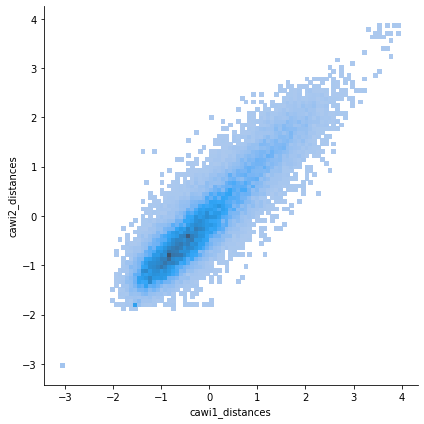

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))
sns.displot(data=distances_df, x='cawi1_distances', y='cawi2_distances', height=6)

## CCA 

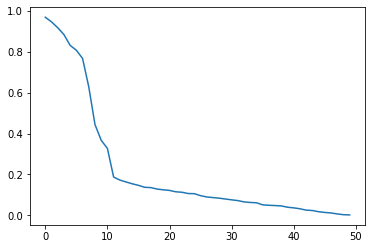

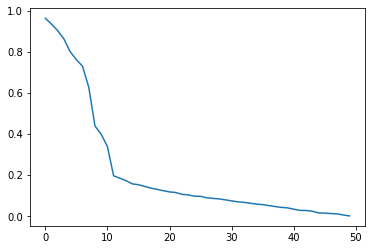

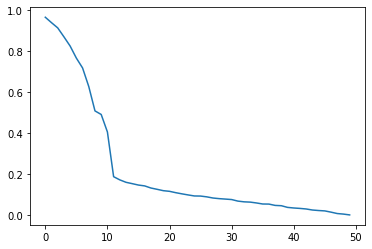

In [ ]:
from sklearn.cross_decomposition import CCA

for exp1 in range(5):
    for exp2 in range(exp1, 5):
        if exp1 == exp2:
            continue
            
        cca = CCA(n_components=50)
        cca.fit(cawi2_embeddings[exp1], cawi2_embeddings[exp2])
        x_c, y_c = cca.transform(cawi2_embeddings[exp1], cawi2_embeddings[exp2])
        
        dimension_correlations = []

        for i in range(50):
            correlation = pearsonr(x_c[:, i], y_c[:, i])
            dimension_correlations.append(correlation[0])
        
        plt.plot(dimension_correlations)   
        plt.show()